Another quick notebook to illustrate how hierarchical loss can help with multiclass predictions of road surfaces.

In [1]:
import pandas as pd
import torch

# Start by reading in the RSC weights
weights_df = pd.read_csv(
    '/data/road_surface_classifier/dataset_multiclass/class_weights.csv')
labels_lv_b = list(weights_df['class_name'])
labels_lv_a = ['paved', 'unpaved']
top_level_map = list(weights_df['top_level'])
class_weights = list(weights_df['weight'])

In [2]:
from rsc.train.rsc_hxe_loss import RSCHXELoss

# Construct hierarchical loss function
hxe_loss = RSCHXELoss(torch.IntTensor(top_level_map), torch.Tensor(class_weights))

In [3]:
df = pd.DataFrame()
df['Level B (Fine) Label'] = labels_lv_b
df['Level A (Coarse) Label'] = [labels_lv_a[e] for e in top_level_map]

df['Original Weight'] = class_weights
df['Level B Weight'] = hxe_loss.lv_b_w_a
df['Level A Weight'] = [hxe_loss.lv_a_w.numpy()[e] for e in top_level_map]

df


,Level B (Fine) Label,Level A (Coarse) Label,Original Weight,Level B Weight,Level A Weight
0,asphalt,paved,0.912725,0.959850,0.950904
1,bricks,paved,2.637934,2.774133,0.950904
2,concrete,paved,0.456363,0.479925,0.950904
3,paving_stones,paved,1.849868,1.945379,0.950904
4,compacted,unpaved,0.916575,0.869251,1.054442
5,dirt,unpaved,0.913273,0.866120,1.054442
6,gravel,unpaved,0.913273,0.866120,1.054442
7,ground,unpaved,1.951101,1.850363,1.054442


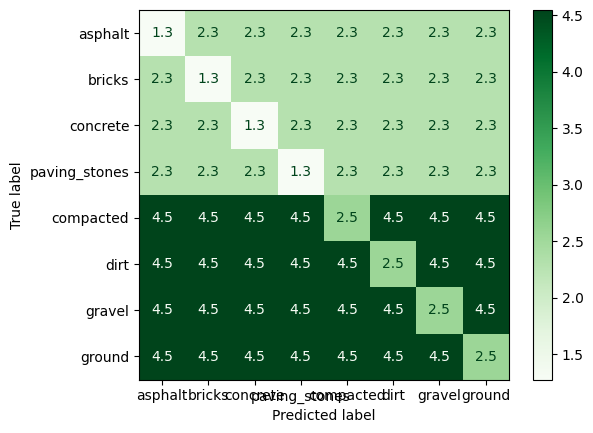

In [4]:
import numpy as np
import matplotlib.pyplot as plt

xe_loss = torch.nn.CrossEntropyLoss(torch.Tensor([1, 1, 1, 1, 2, 2, 2, 2]), reduction='none')

matrix = np.zeros((len(labels_lv_b), len(labels_lv_b)))
for i in range(len(labels_lv_b)):
    for j in range(len(labels_lv_b)):
        pred = torch.zeros((1, len(labels_lv_b)))
        pred[:, i] = 1
        true = torch.LongTensor([j])
        matrix[j, i] = xe_loss(pred, true).numpy()

import sklearn.metrics
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix, display_labels=labels_lv_b)
disp.plot(cmap=plt.cm.Greens)

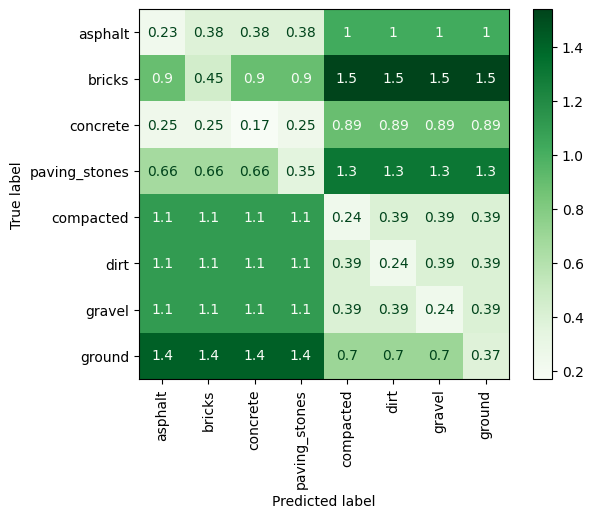

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from rsc.train.rsc_hxe_loss import RSCHXELoss

top_level_map = [0, 0, 0, 0, 1, 1, 1, 1]
hxe_loss = RSCHXELoss(torch.IntTensor(top_level_map), torch.Tensor(class_weights))

matrix = np.zeros((len(labels_lv_b), len(labels_lv_b)))
eps = 1e-1
for i in range(len(labels_lv_b)):
    for j in range(len(labels_lv_b)):
        pred = torch.ones((1, len(labels_lv_b))) * eps
        true = torch.zeros((1, len(labels_lv_b))).bool()
        pred[:, i] = 1 - (len(labels_lv_b) - 1) * eps
        true[:, j] = 1
        matrix[j, i] = hxe_loss(torch.logit(pred), true).numpy()

import sklearn.metrics
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix, display_labels=labels_lv_b)
disp.plot(cmap=plt.cm.Greens, xticks_rotation='vertical')